In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import bambi as bmb
import xarray as xr
import biosc
import biosc.preprocessing

from pymc import HalfCauchy, Model, Normal, sample


In [2]:
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

In [3]:
serif_fonts = plt.rcParams['font.serif']
serif_fonts[0]

'DejaVu Serif'

### biosc for initial data

In [ ]:
from biosc.preprocessing import Preprocessing

In [ ]:
# Example: Load and preprocess data
prep = Preprocessing('Pleiades_GDR3+2MASS+PanSTARRS1+EW_Li.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [ ]:
print(Li_data)

In [ ]:
non_Nan_values = Li_data.dropna()
non_Nan_values

In [ ]:
from biosc.bhm import BayesianModel

In [ ]:
#Example: configure and compile the model
priors = {
    'age': {'dist': 'normal', 'mu': 115, 'sigma': 20},
    'distance': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [ ]:
model.compile(priors, POPho=False, POLi=False)

In [ ]:
#Example: Sample from the posterior distribution
sample = model.sample(draws=500, chains=4)

In [ ]:
model.sample_posterior_predictive()

In [ ]:
#model.save('bayesian_data.nc')

In [ ]:
#Example: Plot posterior distributions
model.plot_trace(var_names=['age', 'distance'])

#Example: Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax', ax = axs[0])
az.plot_ppc(model.idata, var_names = 'flux', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'Li', ax = axs[2])
plt.show()

#Example: Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed parallax [mas]')
ax.set_xlabel('parallax [mas]')
model.plot_QQ('parallax', fig, ax)
plt.show()

#Example: Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed Li')
ax.set_xlabel('Li')
model.plot_QQ('Li', fig, ax)
plt.show()

In [ ]:
mean_posterior_age = model.idata.posterior['age'].median().values
mean_posterior_age

In [ ]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

In [ ]:
az.plot_trace(prior_sample.prior_predictive, figsize=(10, 10))

In [ ]:
az.plot_trace(prior_sample.prior, figsize=(10, 40))

In [ ]:
prior_sample.to_netcdf('prior_sample.nc')

In [ ]:
prior_sample.observed_data['Li']

In [ ]:
prior_sample.prior['M*']

In [ ]:
summary = model.summary()

In [ ]:
summary

#Example: configure and compile the model
priors_uninf = {
    'age': {'dist': 'uniform', 'lower': 70, 'upper': 150},
    'distance': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model_uninf = BayesianModel(parallax_data, m_data, Li_data)
model_uninf.compile(priors_uninf, POPho=False, POLi=True)

model_uninf.sample(chains=4)

model_uninf.sample_posterior_predictive()

#Example: Plot posterior distributions
model_uninf.plot_trace(var_names=['age', 'distance'])

#Example: Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model_uninf.idata, var_names = 'parallax', ax = axs[0])
az.plot_ppc(model_uninf.idata, var_names = 'flux', ax = axs[1])
az.plot_ppc(model_uninf.idata, var_names = 'Li', ax = axs[2])
plt.show()

#Example: Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed parallax [mas]')
ax.set_xlabel('parallax [mas]')
model_uninf.plot_QQ('parallax', fig, ax)
plt.show()

#Example: Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed Li')
ax.set_xlabel('Li')
model_uninf.plot_QQ('Li', fig, ax)
plt.show()

### Load .nc

In [ ]:
import scipy
import os
import netCDF4

from netCDF4 import Dataset as NetCDFFile

In [ ]:
directory = os.getcwd()

folder = 'idata'
path_folder = os.path.join(directory, folder)

file = 'output_test.nc'
path_file = os.path.join(path_folder, file)

directory = os.path.normpath(directory)
path_folder = os.path.normpath(path_folder)
path_file = os.path.normpath(path_file)

print(path_file)

In [ ]:
data_test = NetCDFFile(path_file, 'r')

In [ ]:
data_test

In [ ]:
posterior_group = data_test.groups['posterior']

In [ ]:
posterior_group.variables.keys()

In [ ]:
posterior_group.variables['Li*']

In [ ]:
Li_data = posterior_group.variables['Li*'][:]

In [ ]:
Li_data.shape

In [ ]:
Li_data

In [ ]:
Li_samples = posterior_group.variables['Li*'][:]

Li_samples_reshaped = Li_samples.reshape(-1, 932)

Li_mean = np.mean(Li_samples_reshaped, axis=0)
Li_mean.shape

In [ ]:
Li_mean_simple = np.mean(Li_samples_reshaped, axis=0).data

In [ ]:
Li_summary = pm.summary(posterior_group.variables['Li*'][:])
Li_summary

In [ ]:
M_data = posterior_group.variables['M*'][:]

In [ ]:
M_data.shape

['g', 'bp', 'rp', 'Jmag', 'Hmag', 'Kmag', 'gmag', 'rmag', 'imag', 'ymag', 'zmag']

In [ ]:
J_data = M_data[..., 3]
J_data.shape

In [ ]:
K_data = M_data[..., 5]
K_data.shape

In [ ]:
J_samples = J_data.reshape(-1, 932)

J_samples_mean = np.mean(J_samples, axis=0)
J_samples_mean.shape

K_samples = K_data.reshape(-1, 932)

K_samples_mean = np.mean(K_samples, axis=0)
K_samples_mean.shape

In [ ]:
G_data = M_data[..., 0]

G_samples = G_data.reshape(-1, 932)

G_samples_mean = np.mean(G_samples, axis=0)
G_samples_mean.shape

### Generate data and plot models, priors & posteriors

In [ ]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

In [ ]:
data_model = model.generate_data(mode = 'dist')

In [ ]:
data_model

In [ ]:
items = data_model.items()

for key, value in items:
    print(f'Key {key}')

In [ ]:
dataframe_prior_sample = prior_sample.prior['M*'].to_dataframe()

In [ ]:
data_model['m_data']['data']

In [ ]:
data_model['Li_data']['data']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['m_data']['data']['g'], s=5)
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('G [mag]')
plt.gca().invert_yaxis()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['Li_data']['data'], s=5)
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('A(Li) [dex]')

In [ ]:
path = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

BTSettl_Li = pd.read_csv(path)
BTSettl_Li

In [ ]:
path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/Pleiades_GDR3+2MASS+PanSTARRS1+EW_Li.csv'

Pleiades_Li = pd.read_csv(path)
Pleiades_Li.columns

In [ ]:
BTSettl_Li.rename(columns={'age_Myr': 'age_Gyr'}, inplace=True)
BTSettl_Li.rename(columns={'Teff(K)': 'Teff'}, inplace=True)
BTSettl_Li['age_Gyr'] *= 0.001
BTSettl_Li['A(Li)'] = np.log10(BTSettl_Li['Li']) + 3.3

In [ ]:
#create a dictionary to store dataframes for each isochrone
BTSettl_Li_isochrones = {}

#loop over each row in the BTSettl_Li dataframe
for index, row in BTSettl_Li.iterrows():
    #get the value of age_Myr from the current row
    age_Gyr = row['age_Gyr']
    
    #check if the value of age_Myr already exists as a key in the dictionary
    if age_Gyr not in BTSettl_Li_isochrones:
        #if it doesn't exist, create a new entry in the dictionary with the value of age_Myr as the key
        BTSettl_Li_isochrones[age_Gyr] = []
    
    #add the current row to the corresponding value of age_Myr in the dictionary
    BTSettl_Li_isochrones[age_Gyr].append(row)

#convert each list of rows into a dataframe and replace the list in the dictionary
for age_Gyr, rows in BTSettl_Li_isochrones.items():
    BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)

In [ ]:
Pleiades_Li.columns

In [ ]:
Pleiades_Li['g']

In [ ]:
Pleiades_Li['Jmag']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Pleiades_Li['ALi'], yerr=Pleiades_Li['e_ALi'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['Li_data']['data'], s=5, label='Prior')
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('A(Li) [dex]')

ax.scatter(G_samples_mean - J_samples_mean, Li_mean_simple, s=5, label='Post', color='red')

ax.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['A(Li)'], linewidth = 1, color = 'k', label='0.07 Gyr')
ax.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['A(Li)'], linewidth = 1, color = 'red', label='0.08 Gyr')
ax.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['A(Li)'], linewidth = 1, color = 'orange', label='0.09 Gyr')
ax.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['A(Li)'], linewidth = 1, color = 'green', label='0.1 Gyr')
ax.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['A(Li)'], linewidth = 1, color = 'blue', label='0.12 Gyr')
ax.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['A(Li)'], linewidth = 1, color = 'purple', label='0.15 Gyr')

ax.legend(loc='lower right')



In [ ]:
###Problems with J-K in A(Li) isochrones.

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['Jmag'] - Pleiades_Li['Kmag'], Pleiades_Li['ALi'], yerr=Pleiades_Li['e_ALi'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
ax.scatter(data_model['m_data']['data']['Jmag'] - data_model['m_data']['data']['Kmag'], data_model['Li_data']['data'], s=5, label='Prior')
ax.set_xlabel('J-K [mag]')
ax.set_ylabel('A(Li) [dex]')

ax.scatter(J_samples_mean - K_samples_mean, Li_mean_simple, s=5, label='Post', color='red')

ax.plot(BTSettl_Li_isochrones[0.07]['J'] - BTSettl_Li_isochrones[0.07]['K'], BTSettl_Li_isochrones[0.07]['A(Li)'], linewidth = 1, color = 'k', label='0.07 Gyr')
ax.plot(BTSettl_Li_isochrones[0.08]['J'] - BTSettl_Li_isochrones[0.08]['K'], BTSettl_Li_isochrones[0.08]['A(Li)'], linewidth = 1, color = 'red', label='0.08 Gyr')
ax.plot(BTSettl_Li_isochrones[0.09]['J'] - BTSettl_Li_isochrones[0.09]['K'], BTSettl_Li_isochrones[0.09]['A(Li)'], linewidth = 1, color = 'orange', label='0.09 Gyr')
ax.plot(BTSettl_Li_isochrones[0.1]['J'] - BTSettl_Li_isochrones[0.1]['K'], BTSettl_Li_isochrones[0.1]['A(Li)'], linewidth = 1, color = 'green', label='0.1 Gyr')
ax.plot(BTSettl_Li_isochrones[0.12]['J'] - BTSettl_Li_isochrones[0.12]['K'], BTSettl_Li_isochrones[0.12]['A(Li)'], linewidth = 1, color = 'blue', label='0.12 Gyr')
ax.plot(BTSettl_Li_isochrones[0.15]['J'] - BTSettl_Li_isochrones[0.15]['K'], BTSettl_Li_isochrones[0.15]['A(Li)'], linewidth = 1, color = 'purple', label='0.15 Gyr')

ax.legend(loc='lower right')

In [ ]:
distance = 1 / (data_model['parallax_data']['data'] * 1e-3)
distance_mod = 5 * np.log10(distance) - 5  
data_model['m_data']['data']['G_abs'] = data_model['m_data']['data']['g'] - distance_mod

distance_obs = 1 / (Pleiades_Li['parallax'] * 1e-3)
distance_mod_obs = 5 * np.log10(distance_obs) - 5  
Pleiades_Li['G'] = Pleiades_Li['g'] - distance_mod_obs


In [ ]:
data_model['m_data']['data']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Pleiades_Li['G'], yerr=Pleiades_Li['e_Jmag'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange', zorder=0)
ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['m_data']['data']['G_abs'], s=5, label='Prior')
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('G [mag]')
plt.gca().invert_yaxis()

ax.scatter(G_samples_mean - J_samples_mean, G_samples_mean, s=5, label='Post', zorder=2, color='r')

ax.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['G'], linewidth = 1, color = 'k', label='0.07 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['G'], linewidth = 1, color = 'red', label='0.08 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['G'], linewidth = 1, color = 'orange', label='0.09 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['G'], linewidth = 1, color = 'green', label='0.1 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['G'], linewidth = 1, color = 'blue', label='0.12 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['G'], linewidth = 1, color = 'purple', label='0.15 Gyr', zorder=1)

ax.legend()



In [ ]:
distance = 1 / (data_model['parallax_data']['data'] * 1e-3)
distance_mod = 5 * np.log10(distance) - 5  
data_model['m_data']['data']['J_abs'] = data_model['m_data']['data']['Jmag'] - distance_mod

distance_obs = 1 / (Pleiades_Li['parallax'] * 1e-3)
distance_mod_obs = 5 * np.log10(distance_obs) - 5  
Pleiades_Li['J_abs'] = Pleiades_Li['Jmag'] - distance_mod_obs

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['Jmag'] - Pleiades_Li['Kmag'], Pleiades_Li['J_abs'], yerr=Pleiades_Li['e_Jmag'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange', zorder=0)
ax.scatter(data_model['m_data']['data']['Jmag'] - data_model['m_data']['data']['Kmag'], data_model['m_data']['data']['J_abs'], s=5, label='Prior')
ax.set_xlabel('J-K [mag]')
ax.set_ylabel('J [mag]')
plt.gca().invert_yaxis()

ax.scatter(J_samples_mean - K_samples_mean, J_samples_mean, s=5, label='Post', zorder=2, color='r')

ax.plot(BTSettl_Li_isochrones[0.07]['J'] - BTSettl_Li_isochrones[0.07]['K'], BTSettl_Li_isochrones[0.07]['J'], linewidth = 1, color = 'k', label='0.07 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.08]['J'] - BTSettl_Li_isochrones[0.08]['K'], BTSettl_Li_isochrones[0.08]['J'], linewidth = 1, color = 'red', label='0.08 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.09]['J'] - BTSettl_Li_isochrones[0.09]['K'], BTSettl_Li_isochrones[0.09]['J'], linewidth = 1, color = 'orange', label='0.09 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.1]['J'] - BTSettl_Li_isochrones[0.1]['K'], BTSettl_Li_isochrones[0.1]['J'], linewidth = 1, color = 'green', label='0.1 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.12]['J'] - BTSettl_Li_isochrones[0.12]['K'], BTSettl_Li_isochrones[0.12]['J'], linewidth = 1, color = 'blue', label='0.12 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.15]['J'] - BTSettl_Li_isochrones[0.15]['K'], BTSettl_Li_isochrones[0.15]['J'], linewidth = 1, color = 'purple', label='0.15 Gyr', zorder=1)

ax.legend()



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['Jmag'] - Pleiades_Li['Kmag'], Pleiades_Li['J_abs'], yerr=Pleiades_Li['e_Jmag'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange', zorder=0)
ax.scatter(data_model['m_data']['data']['Jmag'] - data_model['m_data']['data']['Kmag'], data_model['m_data']['data']['J_abs'], s=5, label='Prior')
ax.set_xlabel('J-K [mag]')
ax.set_ylabel('J [mag]')
plt.gca().invert_yaxis()

ax.scatter(J_samples_mean - K_samples_mean, J_samples_mean, s=5, label='Post', zorder=2, color='r')

ax.plot(BTSettl_Li_isochrones[0.07]['J'] - BTSettl_Li_isochrones[0.07]['K'], BTSettl_Li_isochrones[0.07]['J'], linewidth = 1, color = 'k', label='0.07 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.08]['J'] - BTSettl_Li_isochrones[0.08]['K'], BTSettl_Li_isochrones[0.08]['J'], linewidth = 1, color = 'red', label='0.08 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.09]['J'] - BTSettl_Li_isochrones[0.09]['K'], BTSettl_Li_isochrones[0.09]['J'], linewidth = 1, color = 'orange', label='0.09 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.1]['J'] - BTSettl_Li_isochrones[0.1]['K'], BTSettl_Li_isochrones[0.1]['J'], linewidth = 1, color = 'green', label='0.1 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.12]['J'] - BTSettl_Li_isochrones[0.12]['K'], BTSettl_Li_isochrones[0.12]['J'], linewidth = 1, color = 'blue', label='0.12 Gyr', zorder=1)
ax.plot(BTSettl_Li_isochrones[0.15]['J'] - BTSettl_Li_isochrones[0.15]['K'], BTSettl_Li_isochrones[0.15]['J'], linewidth = 1, color = 'purple', label='0.15 Gyr', zorder=1)

ax.set_xlim(0, 2.75)

ax.legend()


In [ ]:
model.idata

for the mean values of Li... each chain and each draw

['g', 'bp', 'rp', 'Jmag', 'Hmag', 'Kmag', 'gmag', 'rmag', 'imag', 'ymag', 'zmag']

### Inference for biosc & DANCe UCDs in Li abundance

In [ ]:
from biosc.preprocessing import Preprocessing

Pleiades_DANCe+GDR3+2MASS+PanSTARRS1+A_Li

In [ ]:
prep = Preprocessing('test_ALi.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [ ]:
print(Li_data)

In [ ]:
non_Nan_values = Li_data.dropna()
non_Nan_values

In [ ]:
from biosc.bhm import BayesianModel

In [ ]:
priors = {
    'age': {'dist': 'normal', 'mu': 115, 'sigma': 20},
    'distance': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

start_values = {'mass': 0.5, 'age': 100, 'distance': 135,
     'σ_F': 0.01, 'σ_Li': 0.5, 'Pb_Li': 0.5, 'Yb_Li': 0.5,
     'Vb_Li': 0.5, 'parallax': 7, 'flux': -0.1,
     'Li': 3
}


In [ ]:
model.compile(priors, POPho=False, POLi=False)

In [ ]:
model.sample(draws=2000, chains=4)

In [ ]:
model.sample_posterior_predictive()

In [ ]:
model.save('output_test_UCDs.nc')

In [ ]:
model.plot_trace(var_names=['age', 'distance'])

In [ ]:
#Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax', ax = axs[0])
az.plot_ppc(model.idata, var_names = 'flux', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'Li', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed parallax [mas]')
ax.set_xlabel('parallax [mas]')
model.plot_QQ('parallax', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed Li')
ax.set_xlabel('Li')
model.plot_QQ('Li', fig, ax)
plt.show()

In [ ]:
mean_posterior_age_UCDs = model.idata.posterior['age'].median().values
mean_posterior_age_UCDs


In [ ]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

In [ ]:
az.plot_trace(prior_sample.prior_predictive, figsize=(10, 10))


In [ ]:
az.plot_trace(prior_sample.prior, figsize=(10, 40))


In [ ]:
prior_sample.to_netcdf('prior_sample_UCDs.nc')


In [ ]:
import scipy
import os
import netCDF4

from netCDF4 import Dataset as NetCDFFile

In [ ]:
directory = os.getcwd()

folder = 'idata'
path_folder = os.path.join(directory, folder)

file = 'output_test_UCDs.nc'
path_file = os.path.join(path_folder, file)

directory = os.path.normpath(directory)
path_folder = os.path.normpath(path_folder)
path_file = os.path.normpath(path_file)

print(path_file)

In [ ]:
data_test = NetCDFFile(path_file, 'r')

posterior_group = data_test.groups['posterior']

Li_data = posterior_group.variables['Li*'][:]

Li_samples = posterior_group.variables['Li*'][:]
Li_samples

Li_samples_reshaped = Li_samples.reshape(-1, 946)

i_mean = np.mean(Li_samples_reshaped, axis=0)

Li_mean_simple = np.mean(Li_samples_reshaped, axis=0).data

Li_summary = pm.summary(posterior_group.variables['Li*'][:])

M_data = posterior_group.variables['M*'][:]

J_data = M_data[..., 3]

K_data = M_data[..., 5]

J_samples = J_data.reshape(-1, 946)

J_samples_mean = np.mean(J_samples, axis=0)

K_samples = K_data.reshape(-1, 946)

K_samples_mean = np.mean(K_samples, axis=0)

G_data = M_data[..., 0]

G_samples = G_data.reshape(-1, 946)

G_samples_mean = np.mean(G_samples, axis=0)


In [ ]:
data_model = model.generate_data(mode = 'dist')

items = data_model.items()

for key, value in items:
    print(f'Key {key}')

dataframe_prior_sample = prior_sample.prior['M*'].to_dataframe()

In [ ]:
path = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

BTSettl_Li = pd.read_csv(path)
BTSettl_Li

In [ ]:
path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi.csv'

Pleiades_Li = pd.read_csv(path)
Pleiades_Li.columns

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Pleiades_Li['ALi'], yerr=Pleiades_Li['e_ALi'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['Li_data']['data'], s=5, label='Prior')
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('A(Li) [dex]')

ax.scatter(G_samples_mean - J_samples_mean, Li_mean_simple, s=5, label='Post', color='red')

ax.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['A(Li)'], linewidth = 1, color = 'k', label='0.07 Gyr')
ax.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['A(Li)'], linewidth = 1, color = 'red', label='0.08 Gyr')
ax.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['A(Li)'], linewidth = 1, color = 'orange', label='0.09 Gyr')
ax.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['A(Li)'], linewidth = 1, color = 'green', label='0.1 Gyr')
ax.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['A(Li)'], linewidth = 1, color = 'blue', label='0.12 Gyr')
ax.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['A(Li)'], linewidth = 1, color = 'purple', label='0.15 Gyr')

ax.legend(loc='lower right')

In [ ]:
prep = Preprocessing('test_ALi.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [ ]:
Li_data

/tmp/ipykernel_3032/4178662609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Li_data['idx'].iloc[:-14] = False
/tmp/ipykernel_3032/4178662609.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Li_data['data'].iloc[:-14] = None
/tmp/ipykernel_3032/4178662609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Li_data['data'].iloc[:-14] = None
/tmp/ipykernel_3032/4178662609.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Li_data['sigma'].iloc[:-14] = None
/tmp/ipykernel_3032/4178662609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Li_data['sigma'].iloc[:-14] = None

In [ ]:
Li_data['idx'].iloc[:-14] = False
Li_data['data'].iloc[:-14] = None
Li_data['sigma'].iloc[:-14] = None

In [ ]:
Li_data
Li_data_obs = Li_data

In [ ]:
from biosc.bhm import BayesianModel

In [ ]:
priors = {
    'age': {'dist': 'normal', 'mu': 120, 'sigma': 20},
    'distance': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [ ]:
model.compile(priors, POPho=False, POLi=True)

In [ ]:
model.sample(draws=500, chains=4)

In [ ]:
model.sample_posterior_predictive()

In [ ]:
model.plot_trace(var_names=['age', 'distance'])

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed parallax [mas]')
ax.set_xlabel('parallax [mas]')
model.plot_QQ('parallax', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('observed Li')
ax.set_xlabel('Li')
model.plot_QQ('Li', fig, ax)
plt.show()

In [ ]:
mean_posterior_age_UCDs = model.idata.posterior['age'].median().values
mean_posterior_age_UCDs

In [ ]:
az.plot_posterior(model.trace, var_names=['age'])

In [ ]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

In [ ]:
model.save('output_test_oUCDs.nc')

In [ ]:
prior_sample.to_netcdf('prior_sample_only_UCDs.nc')

In [ ]:
import scipy
import os
import netCDF4

from netCDF4 import Dataset as NetCDFFile

In [ ]:
directory = os.getcwd()

folder = 'idata'
path_folder = os.path.join(directory, folder)

file = 'output_test_oUCDs.nc'
path_file = os.path.join(path_folder, file)

directory = os.path.normpath(directory)
path_folder = os.path.normpath(path_folder)
path_file = os.path.normpath(path_file)

print(path_file)

In [ ]:
data_test = NetCDFFile(path_file, 'r')

posterior_group = data_test.groups['posterior']

Li_data = posterior_group.variables['Li*'][:]

Li_samples = posterior_group.variables['Li*'][:]
Li_samples

Li_samples_reshaped = Li_samples.reshape(-1, 946)

i_mean = np.mean(Li_samples_reshaped, axis=0)

Li_mean_simple = np.mean(Li_samples_reshaped, axis=0).data

Li_summary = pm.summary(posterior_group.variables['Li*'][:])

M_data = posterior_group.variables['M*'][:]

J_data = M_data[..., 3]

K_data = M_data[..., 5]

J_samples = J_data.reshape(-1, 946)

J_samples_mean = np.mean(J_samples, axis=0)

K_samples = K_data.reshape(-1, 946)

K_samples_mean = np.mean(K_samples, axis=0)

G_data = M_data[..., 0]

G_samples = G_data.reshape(-1, 946)

G_samples_mean = np.mean(G_samples, axis=0)


In [ ]:
data_model = model.generate_data(mode = 'dist')

items = data_model.items()

for key, value in items:
    print(f'Key {key}')

dataframe_prior_sample = prior_sample.prior['M*'].to_dataframe()

In [ ]:
path = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

BTSettl_Li = pd.read_csv(path)
BTSettl_Li

In [ ]:
BTSettl_Li.rename(columns={'age_Myr': 'age_Gyr'}, inplace=True)
BTSettl_Li.rename(columns={'Teff(K)': 'Teff'}, inplace=True)
BTSettl_Li['age_Gyr'] *= 0.001
BTSettl_Li['A(Li)'] = np.log10(BTSettl_Li['Li']) + 3.3

In [ ]:
#create a dictionary to store dataframes for each isochrone
BTSettl_Li_isochrones = {}

#loop over each row in the BTSettl_Li dataframe
for index, row in BTSettl_Li.iterrows():
    #get the value of age_Myr from the current row
    age_Gyr = row['age_Gyr']
    
    #check if the value of age_Myr already exists as a key in the dictionary
    if age_Gyr not in BTSettl_Li_isochrones:
        #if it doesn't exist, create a new entry in the dictionary with the value of age_Myr as the key
        BTSettl_Li_isochrones[age_Gyr] = []
    
    #add the current row to the corresponding value of age_Myr in the dictionary
    BTSettl_Li_isochrones[age_Gyr].append(row)

#convert each list of rows into a dataframe and replace the list in the dictionary
for age_Gyr, rows in BTSettl_Li_isochrones.items():
    BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)

In [ ]:
path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi.csv'

Pleiades_Li = pd.read_csv(path)
Pleiades_Li.columns

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Li_data_obs['data'], yerr=Pleiades_Li['e_ALi'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
ax.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['Li_data']['data'], s=5, label='Prior')
ax.set_xlabel('G-J [mag]')
ax.set_ylabel('A(Li) [dex]')

ax.scatter(G_samples_mean - J_samples_mean, Li_mean_simple, s=5, label='Post', color='red')

ax.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['A(Li)'], linewidth = 1, color = 'k', label='0.07 Gyr')
ax.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['A(Li)'], linewidth = 1, color = 'red', label='0.08 Gyr')
ax.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['A(Li)'], linewidth = 1, color = 'orange', label='0.09 Gyr')
ax.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['A(Li)'], linewidth = 1, color = 'green', label='0.1 Gyr')
ax.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['A(Li)'], linewidth = 1, color = 'blue', label='0.12 Gyr')
ax.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['A(Li)'], linewidth = 1, color = 'purple', label='0.15 Gyr')

ax.legend(loc='lower right')

### Inference for biosc & DANCe UCDs in Li abundance (lower data number; TOPCAT)

In [7]:
import scipy
import os
import netCDF4

from netCDF4 import Dataset as NetCDFFile

In [8]:
def process_idata(file, path_data, path_models, L):
    '''
    file - _ for inference products.
    L - length for stars.
    '''
    
    prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)
    
    directory = os.getcwd()

    folder = 'idata'
    path_folder = os.path.join(directory, folder)

    file = file
    path_file = os.path.join(path_folder, file)

    directory = os.path.normpath(directory)
    path_folder = os.path.normpath(path_folder)
    path_file = os.path.normpath(path_file)

    print(path_file)
    
    data_test = NetCDFFile(path_file, 'r')

    posterior_group = data_test.groups['posterior']

    Li_data = posterior_group.variables['Li*'][:]

    Li_samples = posterior_group.variables['Li*'][:]

    Li_samples_reshaped = Li_samples.reshape(-1, L)

    i_mean = np.mean(Li_samples_reshaped, axis=0)

    Li_mean_simple = np.mean(Li_samples_reshaped, axis=0).data

    Li_summary = pm.summary(posterior_group.variables['Li*'][:])

    M_data = posterior_group.variables['M*'][:]

    J_data = M_data[..., 3]

    K_data = M_data[..., 5]

    J_samples = J_data.reshape(-1, L)

    J_samples_mean = np.mean(J_samples, axis=0)

    K_samples = K_data.reshape(-1, L)

    K_samples_mean = np.mean(K_samples, axis=0)

    G_data = M_data[..., 0]

    G_samples = G_data.reshape(-1, L)

    G_samples_mean = np.mean(G_samples, axis=0)
    
    data_model = model.generate_data(mode = 'dist')

    items = data_model.items()

    for key, value in items:
        print(f'Key {key}')
    
    dataframe_prior_sample = prior_sample.prior['M*'].to_dataframe()
    
    path = path_models

    BTSettl_Li = pd.read_csv(path)
    
    BTSettl_Li.rename(columns={'age_Myr': 'age_Gyr'}, inplace=True)
    BTSettl_Li.rename(columns={'Teff(K)': 'Teff'}, inplace=True)
    BTSettl_Li['age_Gyr'] *= 0.001
    BTSettl_Li['A(Li)'] = np.log10(BTSettl_Li['Li']) + 3.3
    
    #create a dictionary to store dataframes for each isochrone
    BTSettl_Li_isochrones = {}

    #loop over each row in the BTSettl_Li dataframe
    for index, row in BTSettl_Li.iterrows():
        #get the value of age_Myr from the current row
        age_Gyr = row['age_Gyr']

        #check if the value of age_Myr already exists as a key in the dictionary
        if age_Gyr not in BTSettl_Li_isochrones:
            #if it doesn't exist, create a new entry in the dictionary with the value of age_Myr as the key
            BTSettl_Li_isochrones[age_Gyr] = []

        #add the current row to the corresponding value of age_Myr in the dictionary
        BTSettl_Li_isochrones[age_Gyr].append(row)

    #convert each list of rows into a dataframe and replace the list in the dictionary
    for age_Gyr, rows in BTSettl_Li_isochrones.items():
        BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)
        
    path = path_data

    Pleiades_Li = pd.read_csv(path)
    
    distance = 1 / (data_model['parallax_data']['data'] * 1e-3)
    distance_mod = 5 * np.log10(distance) - 5  
    data_model['m_data']['data']['G_abs'] = data_model['m_data']['data']['g'] - distance_mod

    distance_obs = 1 / (Pleiades_Li['parallax'] * 1e-3)
    distance_mod_obs = 5 * np.log10(distance_obs) - 5  
    Pleiades_Li['G'] = Pleiades_Li['g'] - distance_mod_obs

    
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

    ax1.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Pleiades_Li['G'], yerr=Pleiades_Li['g_error'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
    ax1.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['m_data']['data']['G_abs'], s=5, label='Prior')
    ax1.set_xlabel('G-J [mag]')
    ax1.set_ylabel('G [mag]')

    ax1.scatter(G_samples_mean - J_samples_mean, G_samples_mean, s=5, label='Post', color='red')

    ax1.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['G'], linewidth = 1, color = 'k', label='0.07 Gyr')
    ax1.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['G'], linewidth = 1, color = 'red', label='0.08 Gyr')
    ax1.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['G'], linewidth = 1, color = 'orange', label='0.09 Gyr')
    ax1.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['G'], linewidth = 1, color = 'green', label='0.1 Gyr')
    ax1.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['G'], linewidth = 1, color = 'blue', label='0.12 Gyr')
    ax1.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['G'], linewidth = 1, color = 'purple', label='0.15 Gyr')
    
    plt.gca().invert_yaxis()
    
    ax1.legend(loc='upper right')
    
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 8))

    ax2.errorbar(Pleiades_Li['g'] - Pleiades_Li['Jmag'], Pleiades_Li['ALi'], yerr=Pleiades_Li['e_ALi'], fmt='.', capsize=0, linewidth=1, capthick=1, label='Obs', color='orange')
    ax2.scatter(data_model['m_data']['data']['g'] - data_model['m_data']['data']['Jmag'], data_model['Li_data']['data'], s=5, label='Prior')
    ax2.set_xlabel('G-J [mag]')
    ax2.set_ylabel('A(Li) [dex]')

    ax2.scatter(G_samples_mean - J_samples_mean, Li_mean_simple, s=5, label='Post', color='red')

    ax2.plot(BTSettl_Li_isochrones[0.07]['G'] - BTSettl_Li_isochrones[0.07]['J'], BTSettl_Li_isochrones[0.07]['A(Li)'], linewidth = 1, color = 'k', label='0.07 Gyr')
    ax2.plot(BTSettl_Li_isochrones[0.08]['G'] - BTSettl_Li_isochrones[0.08]['J'], BTSettl_Li_isochrones[0.08]['A(Li)'], linewidth = 1, color = 'red', label='0.08 Gyr')
    ax2.plot(BTSettl_Li_isochrones[0.09]['G'] - BTSettl_Li_isochrones[0.09]['J'], BTSettl_Li_isochrones[0.09]['A(Li)'], linewidth = 1, color = 'orange', label='0.09 Gyr')
    ax2.plot(BTSettl_Li_isochrones[0.1]['G'] - BTSettl_Li_isochrones[0.1]['J'], BTSettl_Li_isochrones[0.1]['A(Li)'], linewidth = 1, color = 'green', label='0.1 Gyr')
    ax2.plot(BTSettl_Li_isochrones[0.12]['G'] - BTSettl_Li_isochrones[0.12]['J'], BTSettl_Li_isochrones[0.12]['A(Li)'], linewidth = 1, color = 'blue', label='0.12 Gyr')
    ax2.plot(BTSettl_Li_isochrones[0.15]['G'] - BTSettl_Li_isochrones[0.15]['J'], BTSettl_Li_isochrones[0.15]['A(Li)'], linewidth = 1, color = 'purple', label='0.15 Gyr')

    ax2.legend(loc='lower right')
    
    return ax1, ax2

In [10]:
from biosc.preprocessing import Preprocessing
from biosc.bhm import BayesianModel

In [ ]:
prep = Preprocessing('test_ALi_low.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [ ]:
priors = {
    'Age [Myr]': {'dist': 'normal', 'mu': 120, 'sigma': 20},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [ ]:
priors.keys()

In [ ]:
model.compile(priors, POPho=False, POLi=False)

In [ ]:
model.sample(draws=2000, chains=4)

In [ ]:
model.sample_posterior_predictive()

In [ ]:
model.save('output_test_UCDs_low_plot.nc')

In [ ]:
model.plot_trace(var_names=['Age [Myr]', 'Distance [pc]'])

In [ ]:
#Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax [mas]', ax = axs[0])
az.plot_ppc(model.idata, var_names = r'flux [erg s$^{-1}$ cm$^{-2}$]', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'A(Li) [dex]', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed parallax [mas]')
ax.set_xlabel('Parallax [mas]')
model.plot_QQ('parallax [mas]', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed A(Li) [dex]')
ax.set_xlabel('A(Li) [dex]')
model.plot_QQ('A(Li) [dex]', fig, ax)
plt.show()


In [ ]:
mean_posterior_age_UCDs_low = model.idata.posterior['Age [Myr]'].median().values
mean_posterior_age_UCDs_low


In [ ]:
az.plot_posterior(model.trace, var_names=['Age [Myr]'])

In [ ]:
file = 'output_test_UCDs_low_plot.nc'

path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low.csv'

path_models = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

L = 34

ax1, ax2 = process_idata(file, path_data, path_models, L)

In [20]:
prep = Preprocessing('test_ALi_low_wo_3_UCDs.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [21]:
priors = {
    'Age [Myr]': {'dist': 'normal', 'mu': 120, 'sigma': 20},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [22]:
model.compile(priors, POPho=False, POLi=False)

In [23]:
model.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mass [$M_{\odot}$], Age [Myr], Distance [pc], σ_F, σ_Li]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 375 seconds.


In [24]:
model.sample_posterior_predictive()

Sampling: [A(Li) [dex], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas]]


In [25]:
model.save('output_test_UCDs_low_wo_3_UCDs_plot.nc')

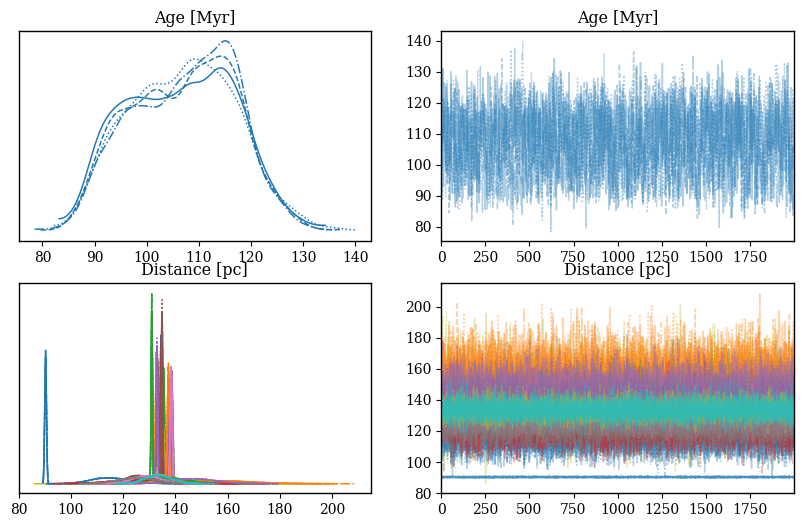

In [26]:
model.plot_trace(var_names=['Age [Myr]', 'Distance [pc]'])

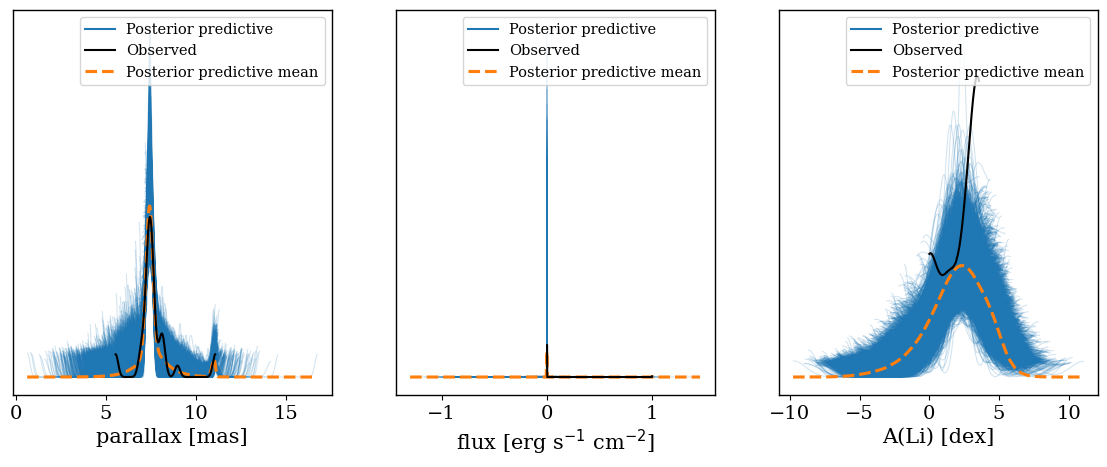

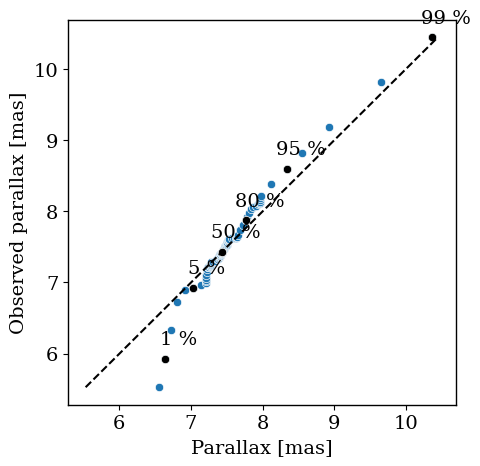

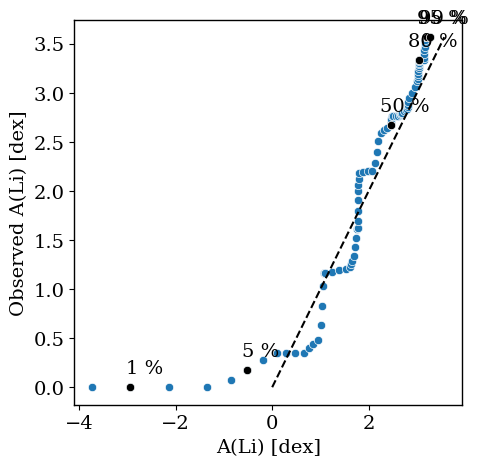

In [27]:
#Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax [mas]', ax = axs[0])
az.plot_ppc(model.idata, var_names = r'flux [erg s$^{-1}$ cm$^{-2}$]', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'A(Li) [dex]', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed parallax [mas]')
ax.set_xlabel('Parallax [mas]')
model.plot_QQ('parallax [mas]', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed A(Li) [dex]')
ax.set_xlabel('A(Li) [dex]')
model.plot_QQ('A(Li) [dex]', fig, ax)
plt.show()


In [28]:
mean_posterior_age_UCDs_low_wo_3_UCDs = model.idata.posterior['Age [Myr]'].median().values
mean_posterior_age_UCDs_low_wo_3_UCDs


array(107.59495076)

<Axes: title={'center': 'Age [Myr]'}>

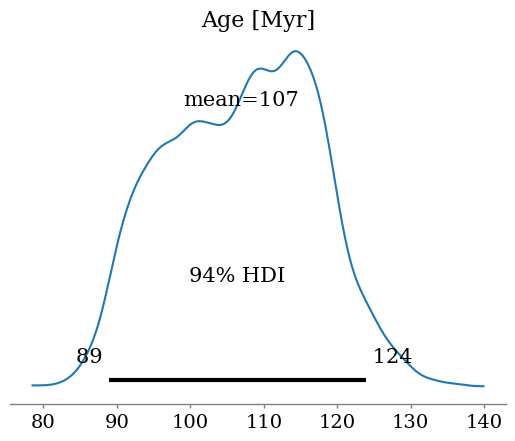

In [29]:
az.plot_posterior(model.trace, var_names=['Age [Myr]'])

Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/idata/output_test_UCDs_low_wo_3_UCDs_plot.nc
Key m_data
Key parallax_data
Key Li_data
Key Age [Myr]


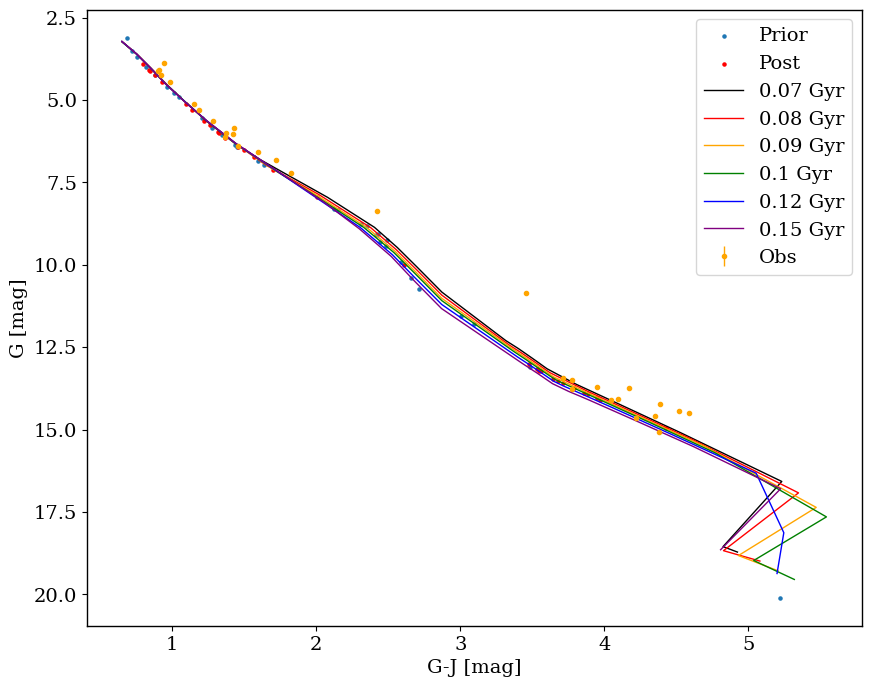

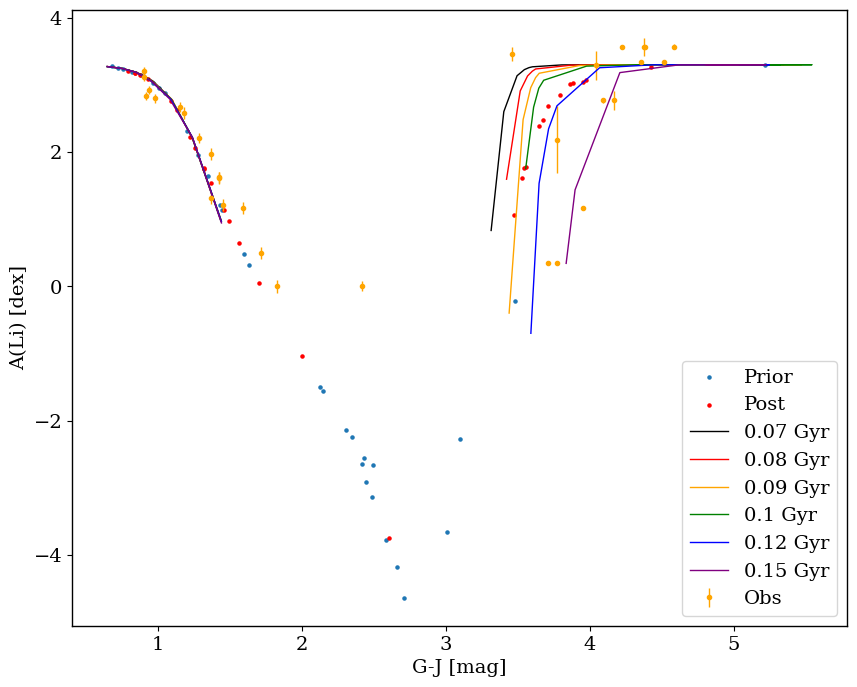

In [30]:
file = 'output_test_UCDs_low_wo_3_UCDs_plot.nc'

path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_wo_3_UCDs.csv'

path_models = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

L = 31

ax1, ax2 = process_idata(file, path_data, path_models, L)

In [31]:
prep = Preprocessing('test_ALi_low_wo_3_UCDs_5_upplim.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
Li_data_obs = Li_data
m_data = prep.get_magnitude(fillna='max')

In [32]:
priors = {
    'Age [Myr]': {'dist': 'normal', 'mu': 120, 'sigma': 20},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [33]:
model.compile(priors, POPho=False, POLi=False)

In [34]:
model.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mass [$M_{\odot}$], Age [Myr], Distance [pc], σ_F, σ_Li]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 268 seconds.


In [35]:
model.sample_posterior_predictive()

Sampling: [A(Li) [dex], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas]]


In [36]:
model.save('output_test_UCDs_low_wo_3_UCDs_5_upplim_plot.nc')

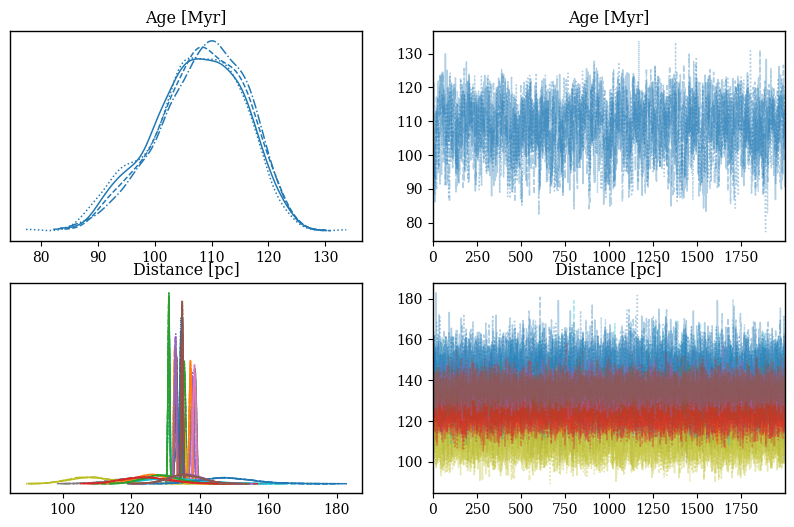

In [37]:
model.plot_trace(var_names=['Age [Myr]', 'Distance [pc]'])

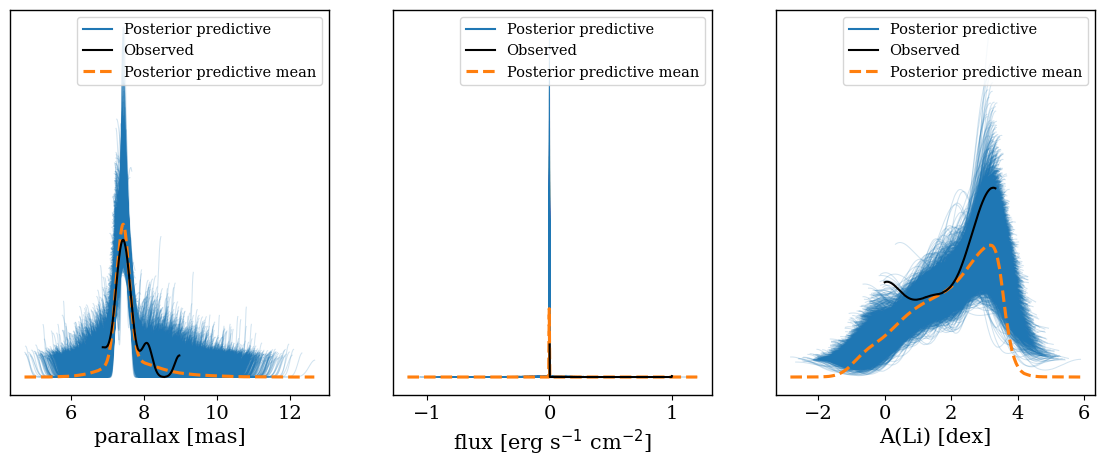

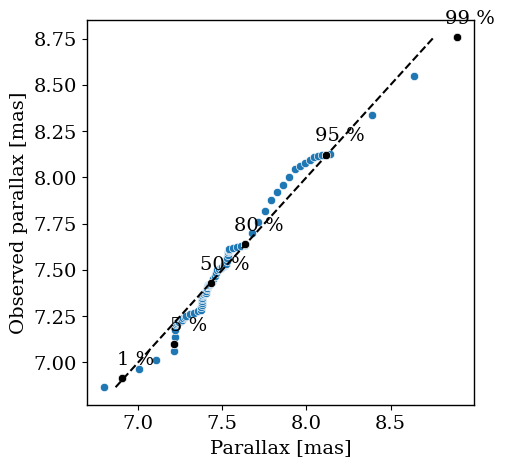

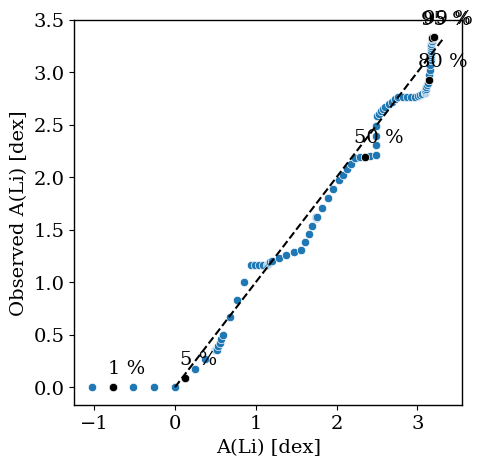

In [38]:
#Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax [mas]', ax = axs[0])
az.plot_ppc(model.idata, var_names = r'flux [erg s$^{-1}$ cm$^{-2}$]', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'A(Li) [dex]', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed parallax [mas]')
ax.set_xlabel('Parallax [mas]')
model.plot_QQ('parallax [mas]', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed A(Li) [dex]')
ax.set_xlabel('A(Li) [dex]')
model.plot_QQ('A(Li) [dex]', fig, ax)
plt.show()


In [39]:
mean_posterior_age_UCDs_low_wo_3_UCDs_5_upplim = model.idata.posterior['Age [Myr]'].median().values
mean_posterior_age_UCDs_low_wo_3_UCDs_5_upplim


array(108.3970464)

<Axes: title={'center': 'Age [Myr]'}>

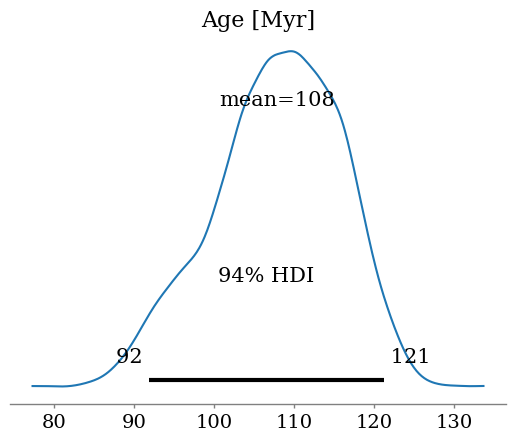

In [40]:
az.plot_posterior(model.trace, var_names=['Age [Myr]'])

In [41]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


'output_test_UCDs_low_wo_3_UCDs_4_upplim.nc'

'/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi.csv'

'/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/idata/output_test_UCDs_low_wo_3_UCDs_5_upplim_plot.nc
Key m_data
Key parallax_data
Key Li_data
Key Age [Myr]


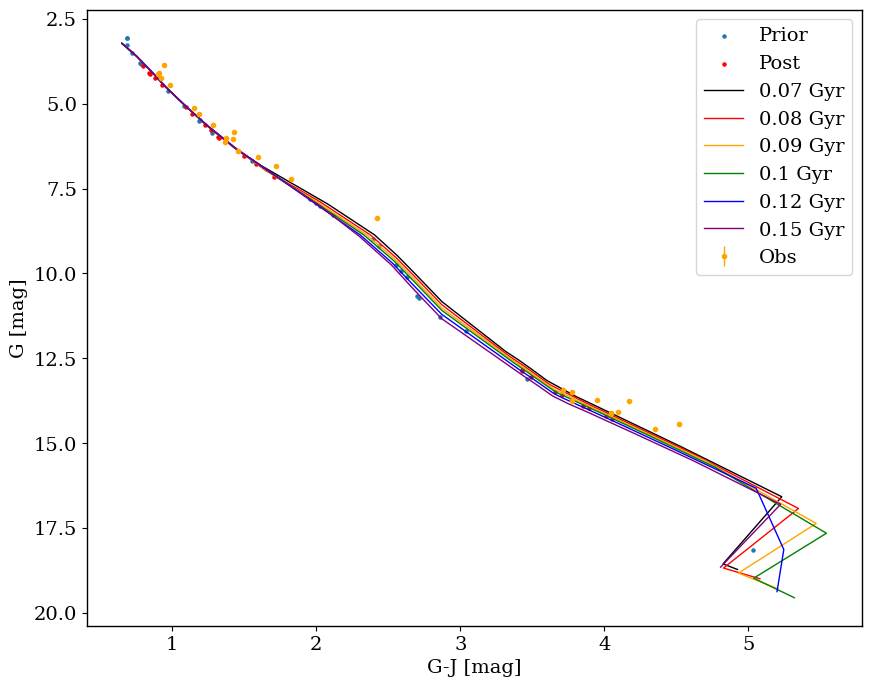

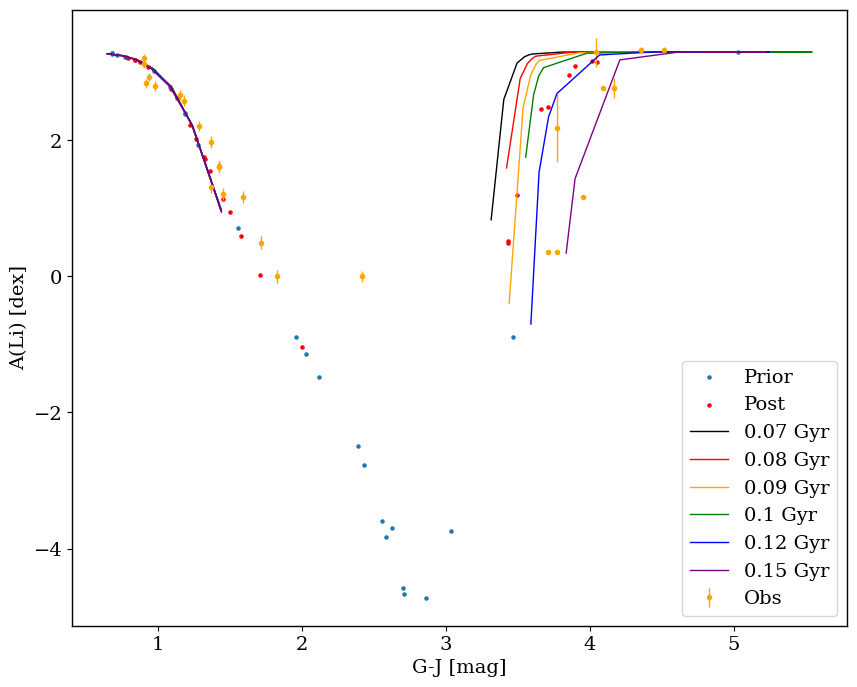

In [42]:
file = 'output_test_UCDs_low_wo_3_UCDs_5_upplim_plot.nc'

path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_wo_3_UCDs_5_upplim.csv'

path_models = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

L = 26

ax1, ax2 = process_idata(file, path_data, path_models, L)

In [20]:
prep = Preprocessing('test_ALi_low_wo_3_UCDs_1_outlier.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
Li_data_obs = Li_data
m_data = prep.get_magnitude(fillna='max')

In [21]:
priors = {
    'Age [Myr]': {'dist': 'normal', 'mu': 120, 'sigma': 20},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [22]:
model.compile(priors, POPho=False, POLi=False)

In [23]:
model.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mass [$M_{\odot}$], Age [Myr], Distance [pc], σ_F, σ_Li]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1342 seconds.


In [24]:
model.sample_posterior_predictive()

Sampling: [A(Li) [dex], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas]]


In [25]:
model.save('output_test_UCDs_low_wo_3_UCDs_1_outlier.nc')

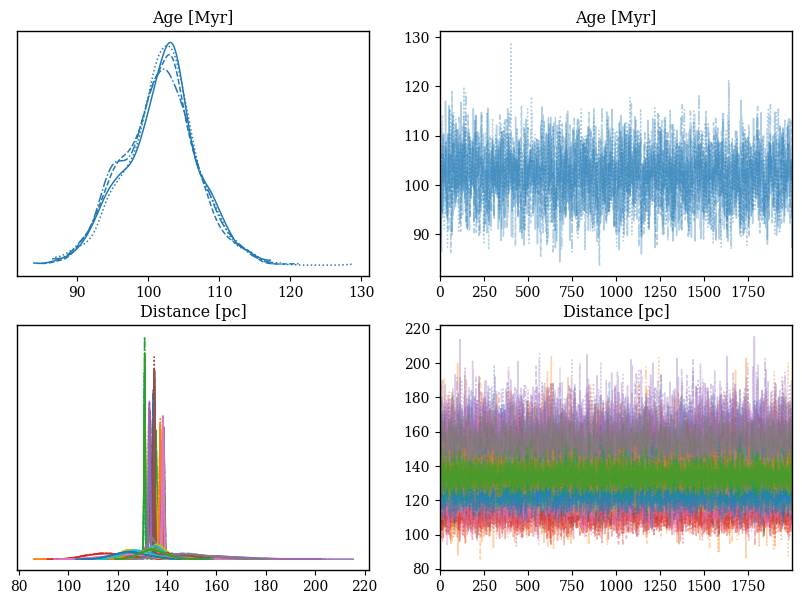

In [26]:
model.plot_trace(var_names=['Age [Myr]', 'Distance [pc]'])

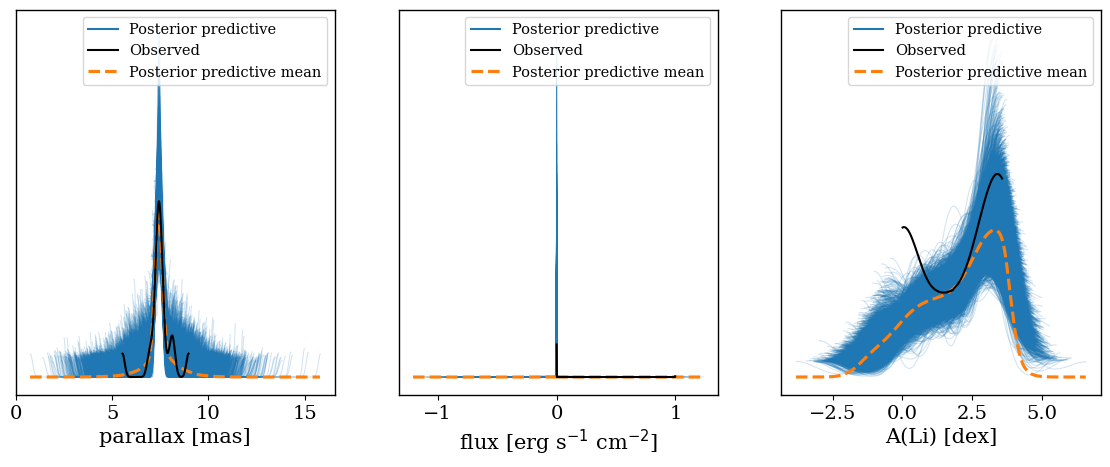

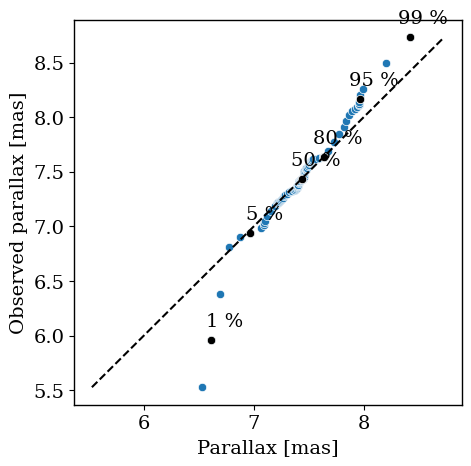

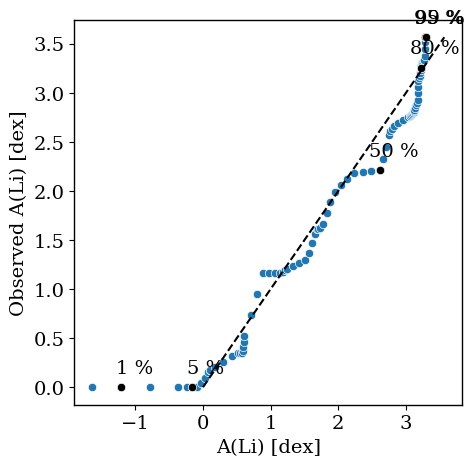

In [30]:
#Plot posterior predictive checks
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax [mas]', ax = axs[0])
az.plot_ppc(model.idata, var_names = r'flux [erg s$^{-1}$ cm$^{-2}$]', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'A(Li) [dex]', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed parallax [mas]')
ax.set_xlabel('Parallax [mas]')
model.plot_QQ('parallax [mas]', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed A(Li) [dex]')
ax.set_xlabel('A(Li) [dex]')
model.plot_QQ('A(Li) [dex]', fig, ax)
plt.show()


In [32]:
mean_posterior_age_UCDs_low_wo_3_UCDs_5_upplim = model.idata.posterior['Age [Myr]'].median().values
mean_posterior_age_UCDs_low_wo_3_UCDs_5_upplim


array(101.96639473)

<Axes: title={'center': 'Age [Myr]'}>

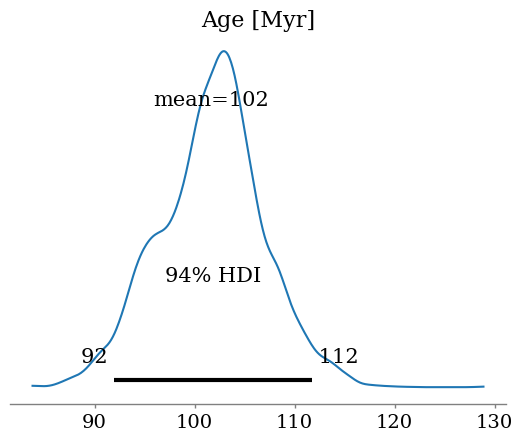

In [31]:
az.plot_posterior(model.trace, var_names=['Age [Myr]'])

In [27]:
prior_sample = model.sample_prior_predictive(samples = 500, return_inferencedata = True)

Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/idata/output_test_UCDs_low_wo_3_UCDs_1_outlier.nc
Key m_data
Key parallax_data
Key Li_data
Key Age [Myr]


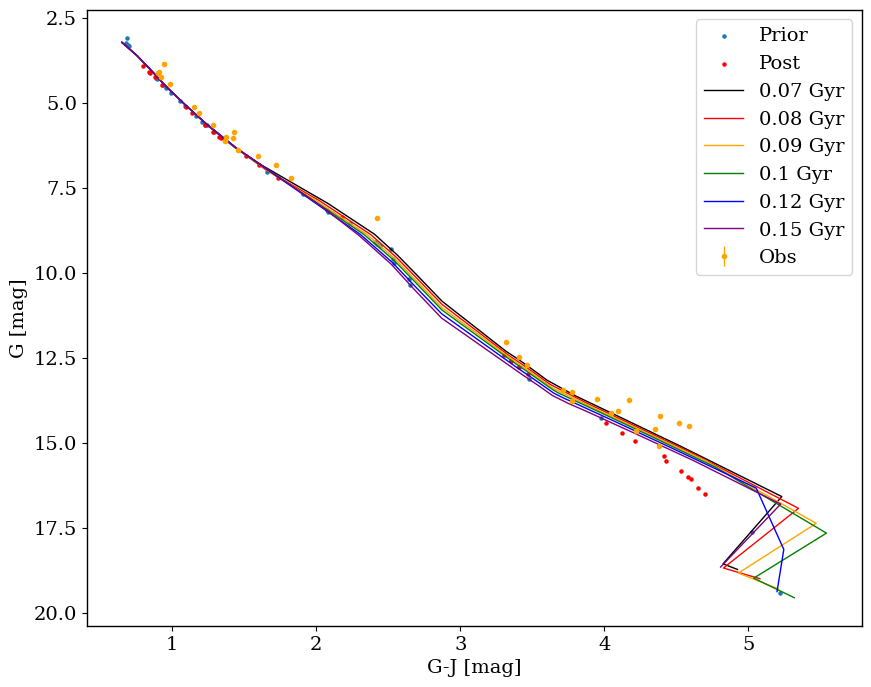

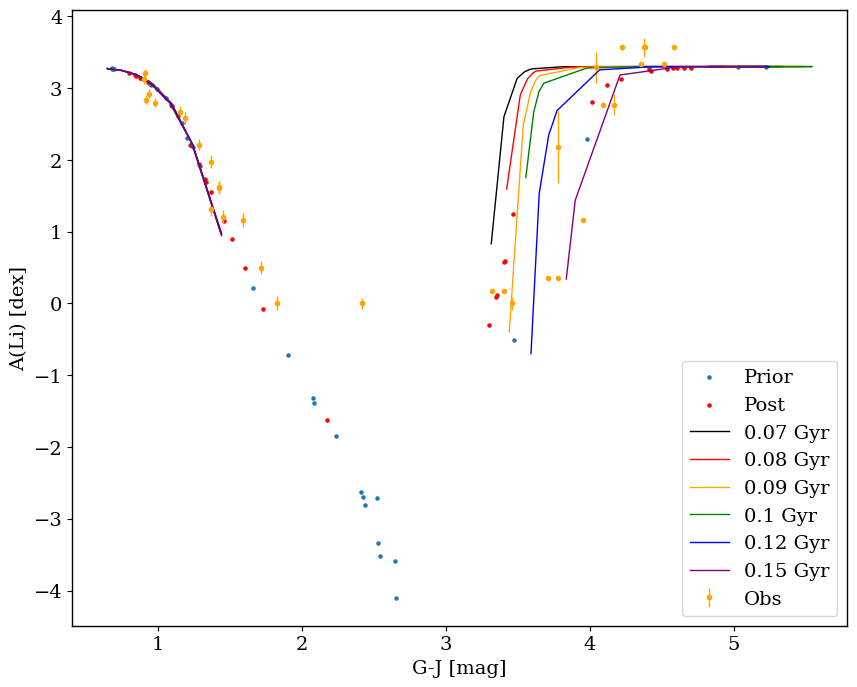

In [29]:
file = 'output_test_UCDs_low_wo_3_UCDs_1_outlier.nc'

path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_wo_3_UCDs_1_outlier.csv'

path_models = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

L = 33

ax1, ax2 = process_idata(file, path_data, path_models, L)

Now with POLi = True:

In [35]:
prep = Preprocessing('test_ALi_low.csv', sortPho=False)
parallax_data = prep.get_parallax()
Li_data = prep.get_Li()
m_data = prep.get_magnitude(fillna='max')

In [36]:
priors = {
    'Age [Myr]': {'dist': 'normal', 'mu': 130, 'sigma': 10},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}

model = BayesianModel(parallax_data, m_data, Li_data)

In [37]:
model.compile(priors, POPho=False, POLi=True)

In [38]:
model.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mass [$M_{\odot}$], Age [Myr], Distance [pc], σ_F, σ_Li, Pb_Li, Yb_Li, Vb_Li]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 619 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [39]:
model.sample_posterior_predictive()

Sampling: [A(Li) [dex], flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas]]


In [40]:
model.save('output_test_UCDs_low_plot_POLi.nc')

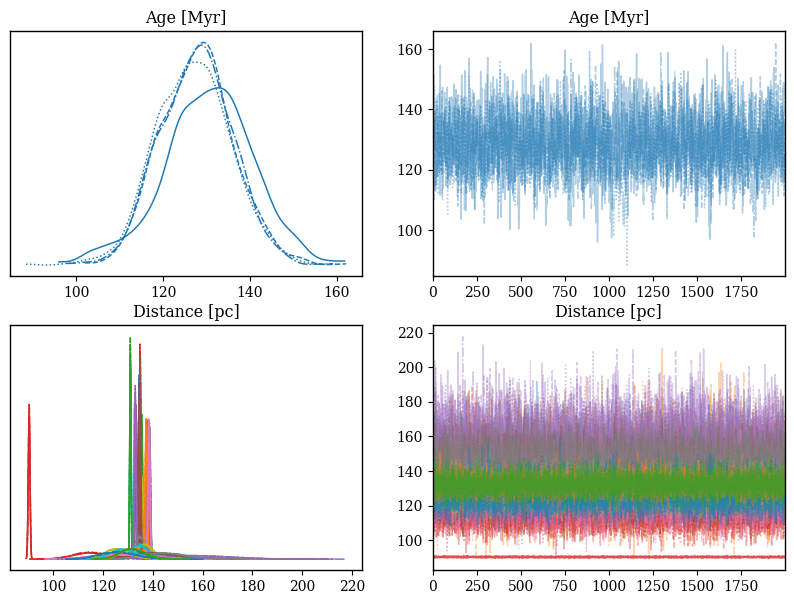

In [41]:
model.plot_trace(var_names=['Age [Myr]', 'Distance [pc]'])

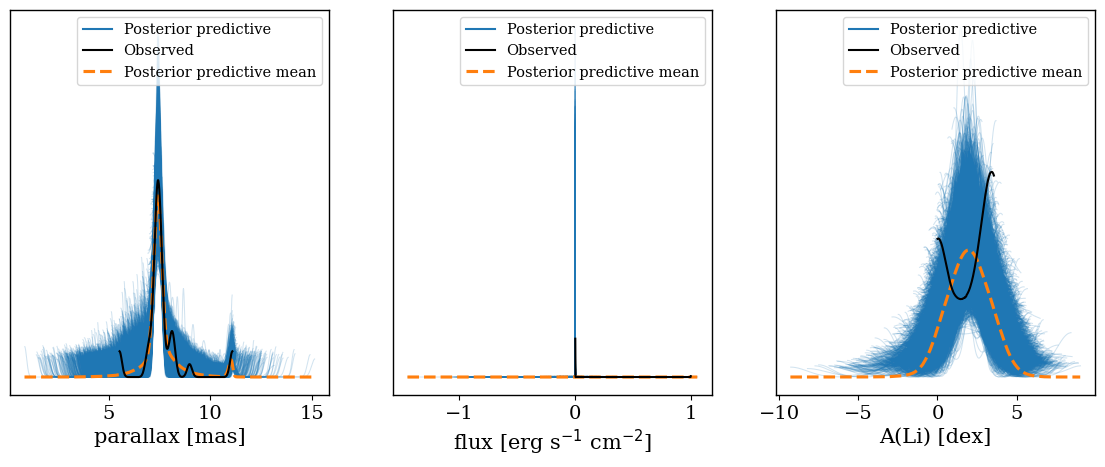

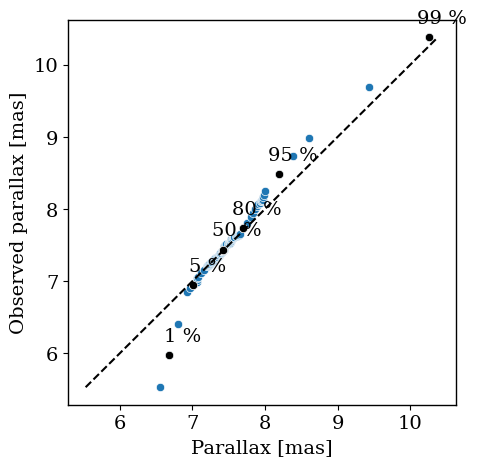

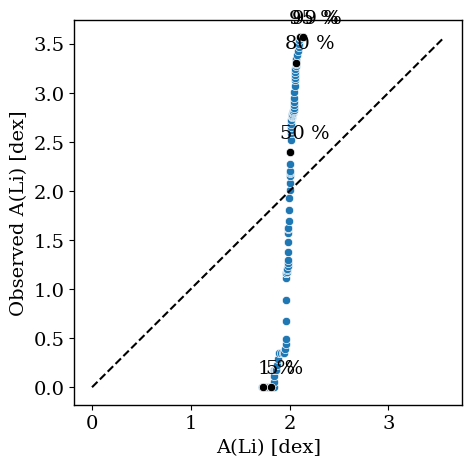

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
az.plot_ppc(model.idata, var_names = 'parallax [mas]', ax = axs[0])
az.plot_ppc(model.idata, var_names = r'flux [erg s$^{-1}$ cm$^{-2}$]', ax = axs[1])
az.plot_ppc(model.idata, var_names = 'A(Li) [dex]', ax = axs[2])
plt.show()

#Plot QQ for parallax
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed parallax [mas]')
ax.set_xlabel('Parallax [mas]')
model.plot_QQ('parallax [mas]', fig, ax)
plt.show()

#Plot QQ for Li
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylabel('Observed A(Li) [dex]')
ax.set_xlabel('A(Li) [dex]')
model.plot_QQ('A(Li) [dex]', fig, ax)
plt.show()

In [43]:
mean_posterior_age_UCDs_low_POLi = model.idata.posterior['Age [Myr]'].median().values
mean_posterior_age_UCDs_low_POLi

array(128.26698638)

<Axes: title={'center': 'Age [Myr]'}>

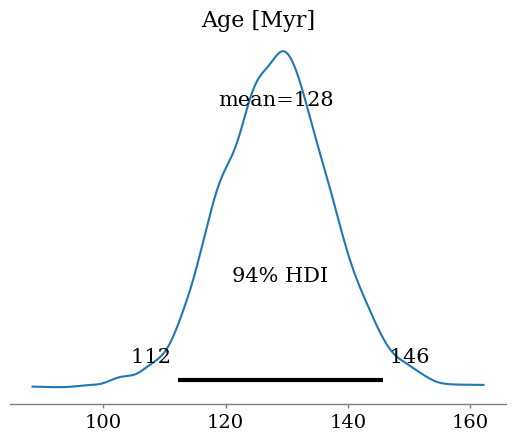

In [44]:
az.plot_posterior(model.trace, var_names=['Age [Myr]'])

Sampling: [A(Li) [dex], Age [Myr], Distance [pc], Mass [$M_{\odot}$], Pb_Li, Vb_Li, Yb_Li, flux [erg s$^{-1}$ cm$^{-2}$], parallax [mas], σ_F, σ_Li]


/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/idata/output_test_UCDs_low_plot_POLi.nc
Key m_data
Key parallax_data
Key Li_data
Key Age [Myr]


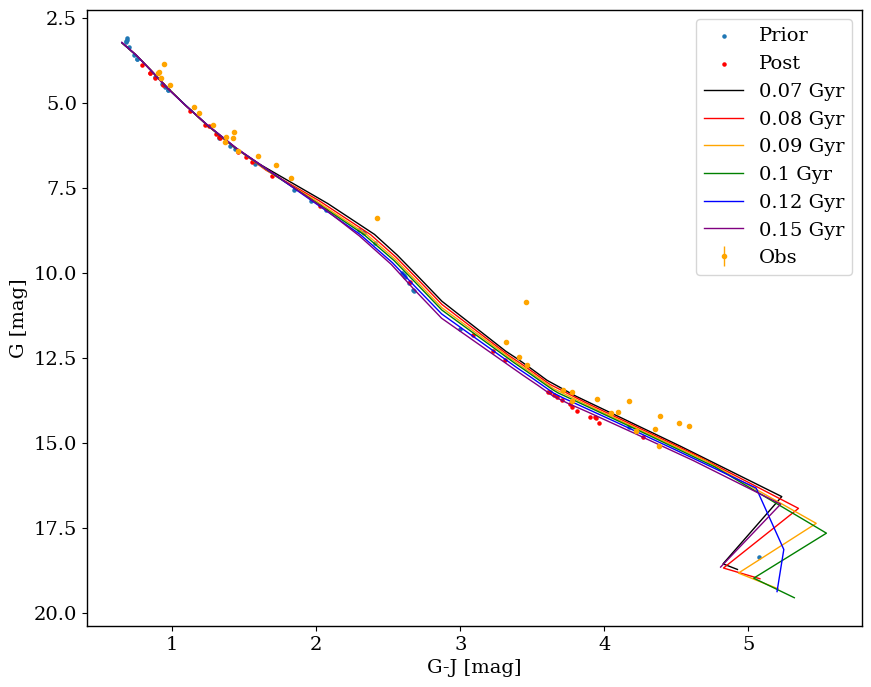

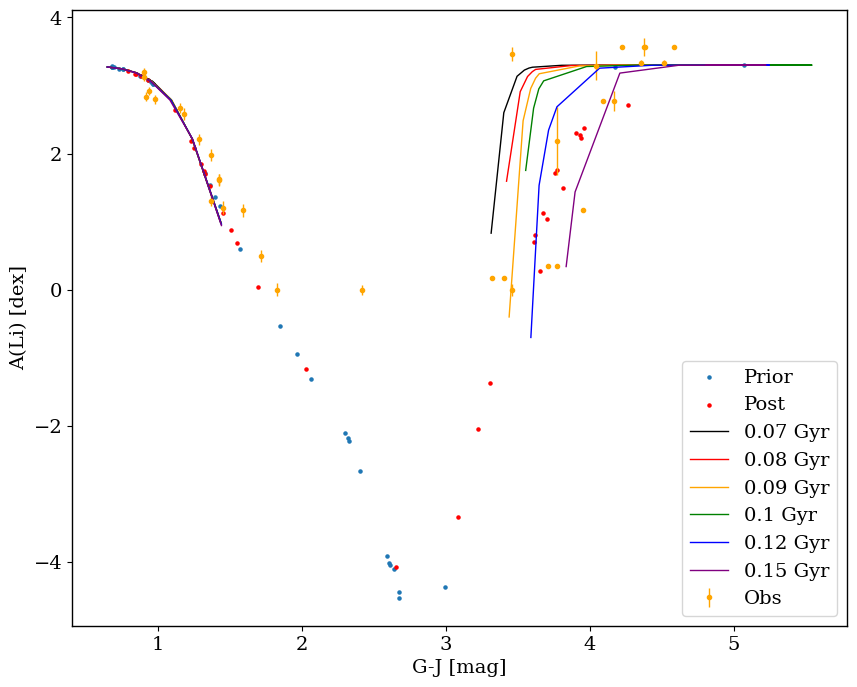

In [45]:
file = 'output_test_UCDs_low_plot_POLi.nc'

path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low.csv'

path_models = '/pcdisk/dalen/lgonzalez/RepGit/Biosc_work/biosc/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'

L = 34

ax1, ax2 = process_idata(file, path_data, path_models, L)